
## Assignment 5
Perform image segmentation on all images in the dataset, using the normalized cut algorithm running on the top of superpixels rather than on raw pixels. For each image compute an accuracy metric (which one it is up to you to decide) measuring the overlap between the segments identified by NCUT and the ground truth horse semantic segmentation. Provide a table summarizing the average segmentation accuracy on all images, plus present 2 examples of images that are well-segmented (according to the above defined metric).

Hint: in Python, you have an NCut implementation in the scikit-image library; in Matlab, you can use the original NCut implementation here. Superpixels are implemented both in Matlab as well as in OpenCV. Feel free to pickup the implementation you liked most (and motivate the choice).

# Superpixeling 

Superpixeling is a preprocessing step in image segmentation that consists in grouping together similar pixels to perform a cheap, local oversegmentation. The image processing library **scikit-image** was utilized for image processing [1].



Reference:

[1] Stéfan van der Walt, Johannes L. Schönberger, Juan Nunez-Iglesias, François Boulogne, Joshua D. Warner, Neil Yager, Emmanuelle Gouillart, Tony Yu, and the scikit-image contributors. scikit-image: Image processing in Python. PeerJ 2:e453 (2014) https://doi.org/10.7717/peerj.453


In [2]:
from skimage import segmentation, color, graph
from matplotlib import pyplot as plt
import numpy as np

#from utils1 import * # contains methods to import the dataset and print images

from skimage import io
import matplotlib.pyplot as plt
import os

def load_images_from_folder(folder):
    images = []
    for filename in sorted(os.listdir(folder)):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            img = io.imread(img_path)
            if img is not None:
                images.append(img)
    return images


def print_image(image, title):
    plt.tight_layout()
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(title)

In [3]:
# load the dataset
folder_path = '../datasets/weizmann_horse_db/horse'
images = load_images_from_folder(folder_path)

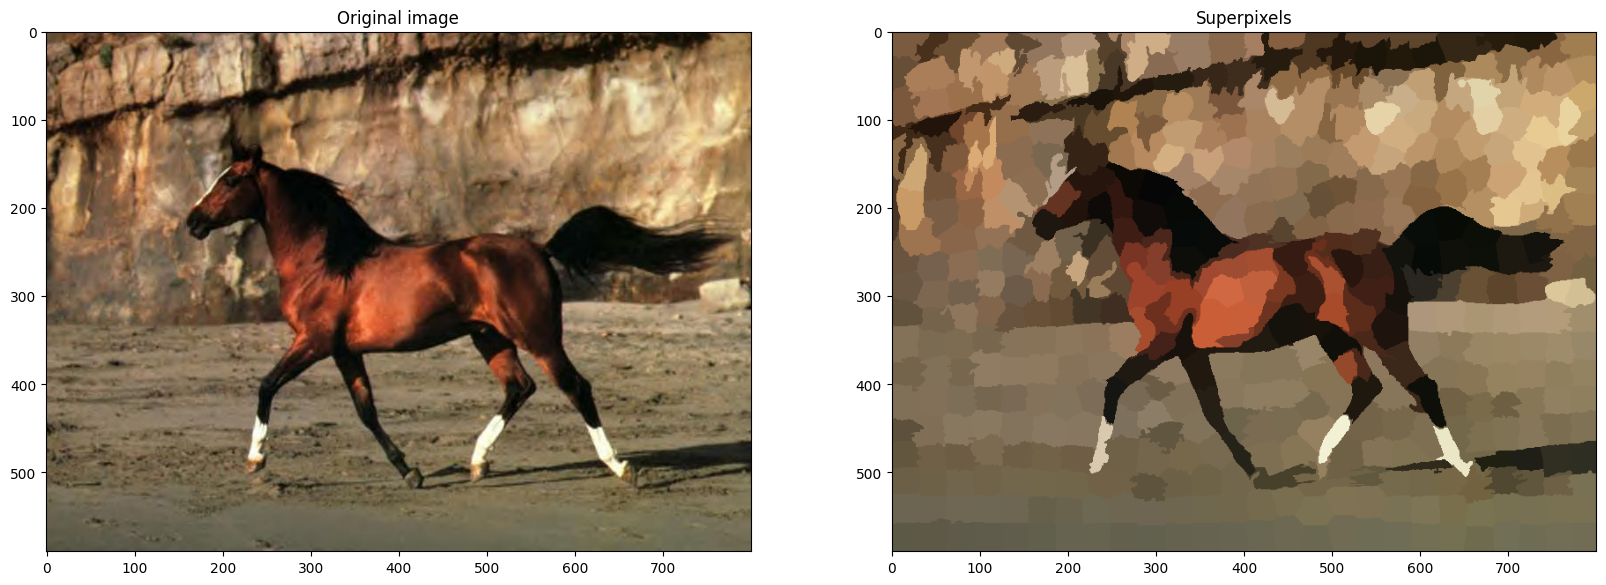

In [4]:

image = images[0]
num_superpixels = 500

labels = segmentation.slic(image, n_segments=num_superpixels, compactness=20, start_label=1)
color_segment = color.label2rgb(labels, image, kind='avg')

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(image)
ax[0].set_title('Original image')
ax[1].imshow(color_segment)
ax[1].set_title('Superpixels')
plt.show()


RAG with 472 nodes and 1343 edges


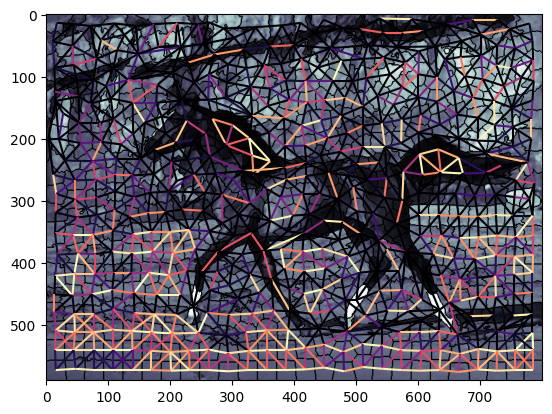

In [5]:

RAG_similarity = graph.rag_mean_color(image, labels, mode='similarity')
print(RAG_similarity)
graph2 = graph.show_rag(labels=labels, rag=RAG_similarity, image=image)

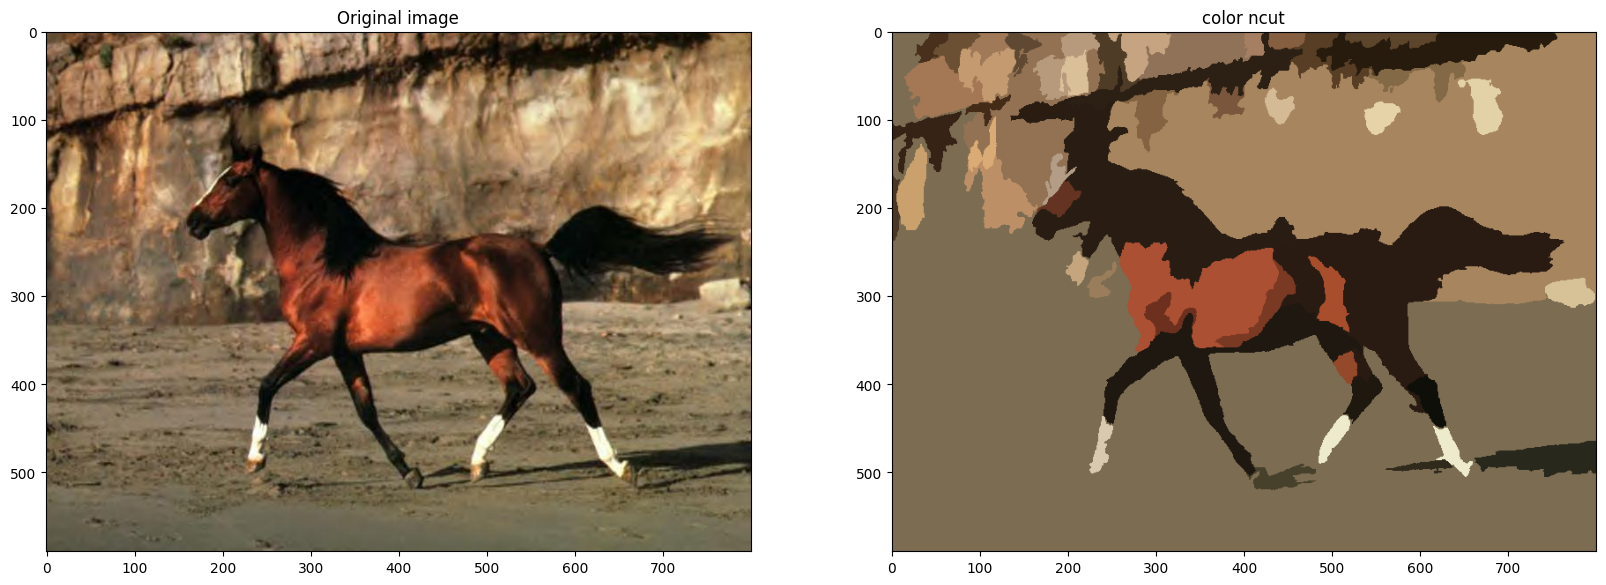

In [6]:
ncut = graph.cut_normalized(labels, rag=RAG_similarity)
color_ncut = color.label2rgb(ncut, image, kind='avg', bg_label=0)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(image)
ax[0].set_title('Original image')
ax[1].imshow(color_ncut)
ax[1].set_title('color ncut')
plt.show()

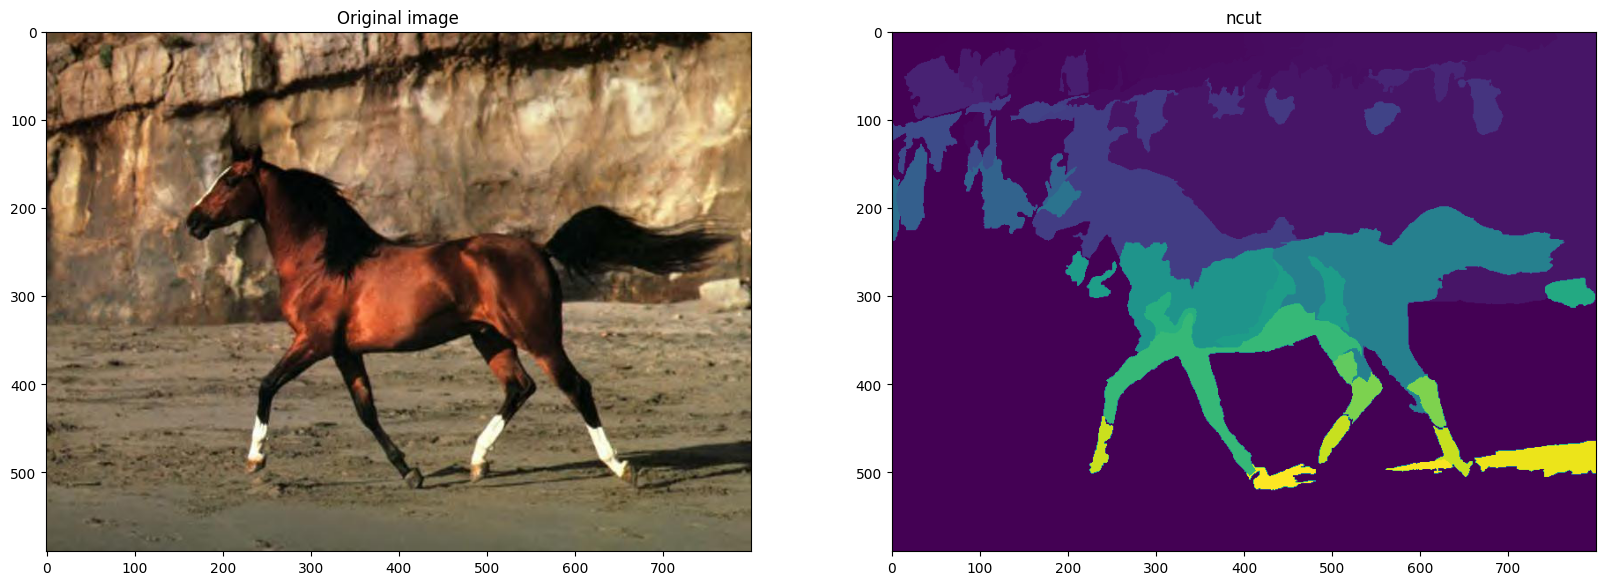

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(image)
ax[0].set_title('Original image')
ax[1].imshow(ncut)
ax[1].set_title('ncut')
plt.show()

In [8]:
grey_cut = color.rgb2gray(color_ncut)

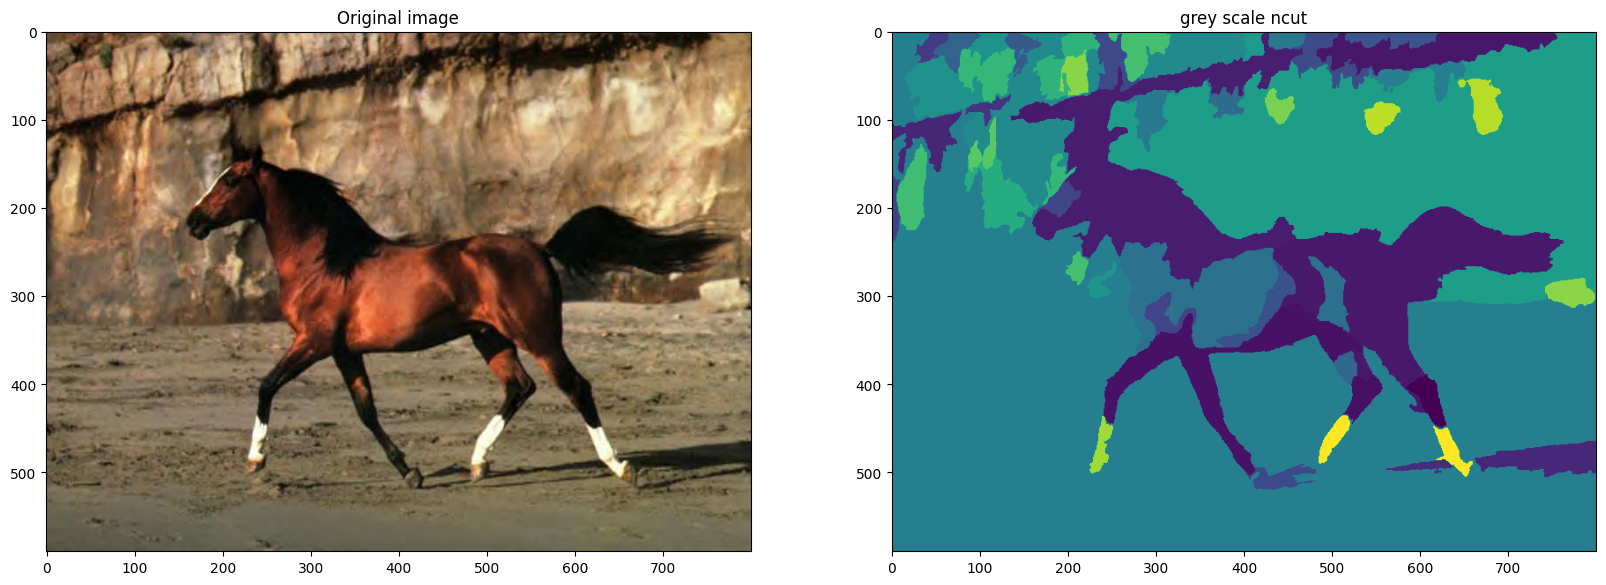

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(image)
ax[0].set_title('Original image')
ax[1].imshow(grey_cut)
ax[1].set_title('grey scale ncut')
plt.show()

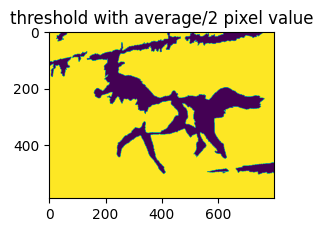

In [10]:
average = np.average(grey_cut)/2

ncut_threshold = grey_cut.copy()
ncut_threshold[ncut_threshold < average] = 0
ncut_threshold[ncut_threshold >= average] = 1
print_image(ncut_threshold, f'threshold with average/2 pixel value')

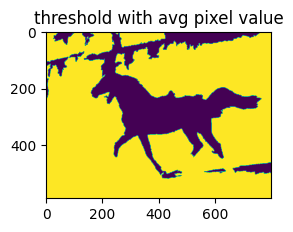

In [11]:
average = np.average(grey_cut)

ncut_threshold = grey_cut.copy()
ncut_threshold[ncut_threshold < average] = 0
ncut_threshold[ncut_threshold >= average] = 1
print_image(ncut_threshold, f'threshold with avg pixel value')

In [12]:
from utils1 import load_images_from_folder
folder_path = '../datasets/weizmann_horse_db/mask'
imagess = load_images_from_folder(folder_path)

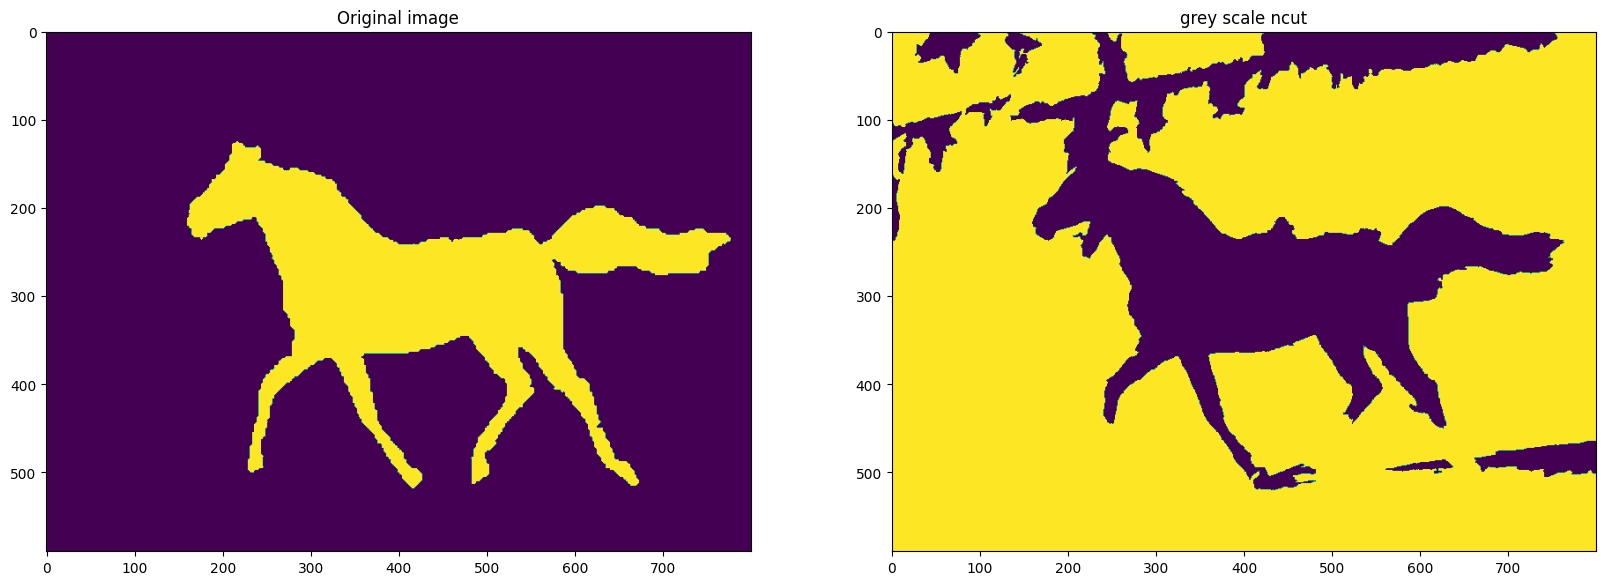

In [13]:
mask = imagess[0]
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(mask)
ax[0].set_title('Original image')
ax[1].imshow(ncut_threshold)
ax[1].set_title('grey scale ncut')
plt.show()

In [14]:
from sklearn.metrics import jaccard_score
import numpy as np


img_true=np.array(mask).ravel()
img_pred=np.array(ncut_threshold).ravel()
iou = max(jaccard_score(img_true, img_pred), jaccard_score(img_true, (1-img_pred)))

In [15]:
iou

0.6101824925190711

# Here we start applying what shown above to all the dataset

In [16]:
def ncut(image):
    labels = segmentation.slic(image, n_segments=500, compactness=20, start_label=1)
    #color_segment = color.label2rgb(labels, image, kind='avg')
    
    RAG_similarity = graph.rag_mean_color(image, labels, mode='similarity')
    ncut_ = graph.cut_normalized(labels, rag=RAG_similarity)
    color_ncut = color.label2rgb(ncut_, image, kind='avg')
    grey_cut = color.rgb2gray(color_ncut)

    return grey_cut

In [17]:
def metric(image1, mask):

    image = ncut(image1)

    ncut_threshold = image.copy()
    ncut_threshold2 = image.copy()
    
    average = np.average(image)

    ncut_threshold[ncut_threshold < average] = 0
    ncut_threshold[ncut_threshold >= average] = 1

    ncut_threshold2[ncut_threshold2 < average/2] = 0
    ncut_threshold2[ncut_threshold2 >= average/2] = 1

    img_true=np.array(mask).ravel()
    img_pred=np.array(ncut_threshold).ravel()
    img_pred2=np.array(ncut_threshold2).ravel()
    iou = max(jaccard_score(img_true, img_pred), jaccard_score(img_true, (1-img_pred)), 
              jaccard_score(img_true, img_pred2), jaccard_score(img_true, (1-img_pred2)))
    return iou

In [18]:
from tqdm import tqdm

accs = []

with tqdm(total=len(images), desc="image", colour='yellow') as pbar:
    for i in range(len(images)):
        accs.append(metric(images[i], imagess[i]))
        pbar.update(1)

image:   0%|          | 0/327 [00:00<?, ?it/s]

image: 100%|██████████| 327/327 [42:40<00:00,  7.83s/it]  


# Accuracy metric 

to measure the overlap between the segments identified by NCUT and the ground truth horse semantic segmentation the IoU metric, or Jaccard similarity coefficient score implemented by skimage was used.

### Jaccard similarity coefficient score

The Jaccard score is calculated as the intersection of the obtained mask and the ground truth mask divided by the union of the two masks:

$$J(A, B) = \frac{|A ∩ B|}{|A ∪ B|}$$

Where:
- A is the obtained binary mask.
- B is the ground truth binary mask.
- |A ∩ B| is the number of pixels where both A and B are 1 (intersection).
- |A ∪ B| is the number of pixels where either A or B or both are 1 (union).


# results

## picking the 2 best

In [19]:
accs2 = accs.copy()
accs2.sort()
bests = accs2[-2:]
bests

[0.9460050278718986, 0.9615406022151722]

In [20]:
bests_index = [accs.index(i) for i in bests]
bests_index

[127, 316]

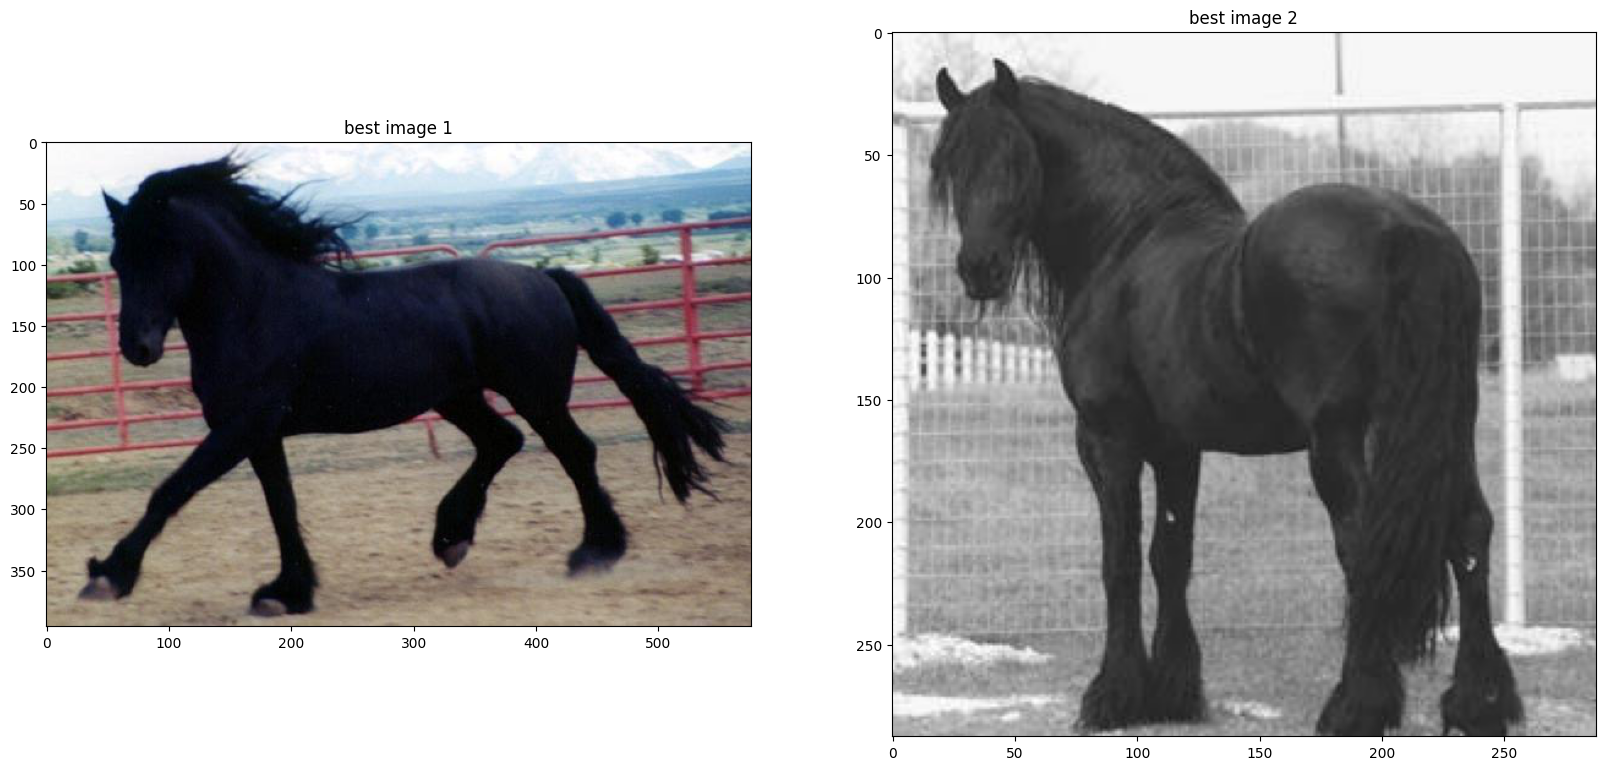

In [21]:
# print the 2 best images
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(images[bests_index[0]])
plt.title('best image 1')
plt.subplot(1, 2, 2)
plt.imshow(images[bests_index[1]])
plt.title('best image 2')
plt.show()



In [34]:
best1cut = ncut(images[bests_index[0]])
ncut_threshold = best1cut.copy()
ncut_threshold2 = best1cut.copy()

average = np.average(best1cut)

ncut_threshold[ncut_threshold < average] = 0
ncut_threshold[ncut_threshold >= average] = 1

ncut_threshold2[ncut_threshold2 < average/2] = 0
ncut_threshold2[ncut_threshold2 >= average/2] = 1



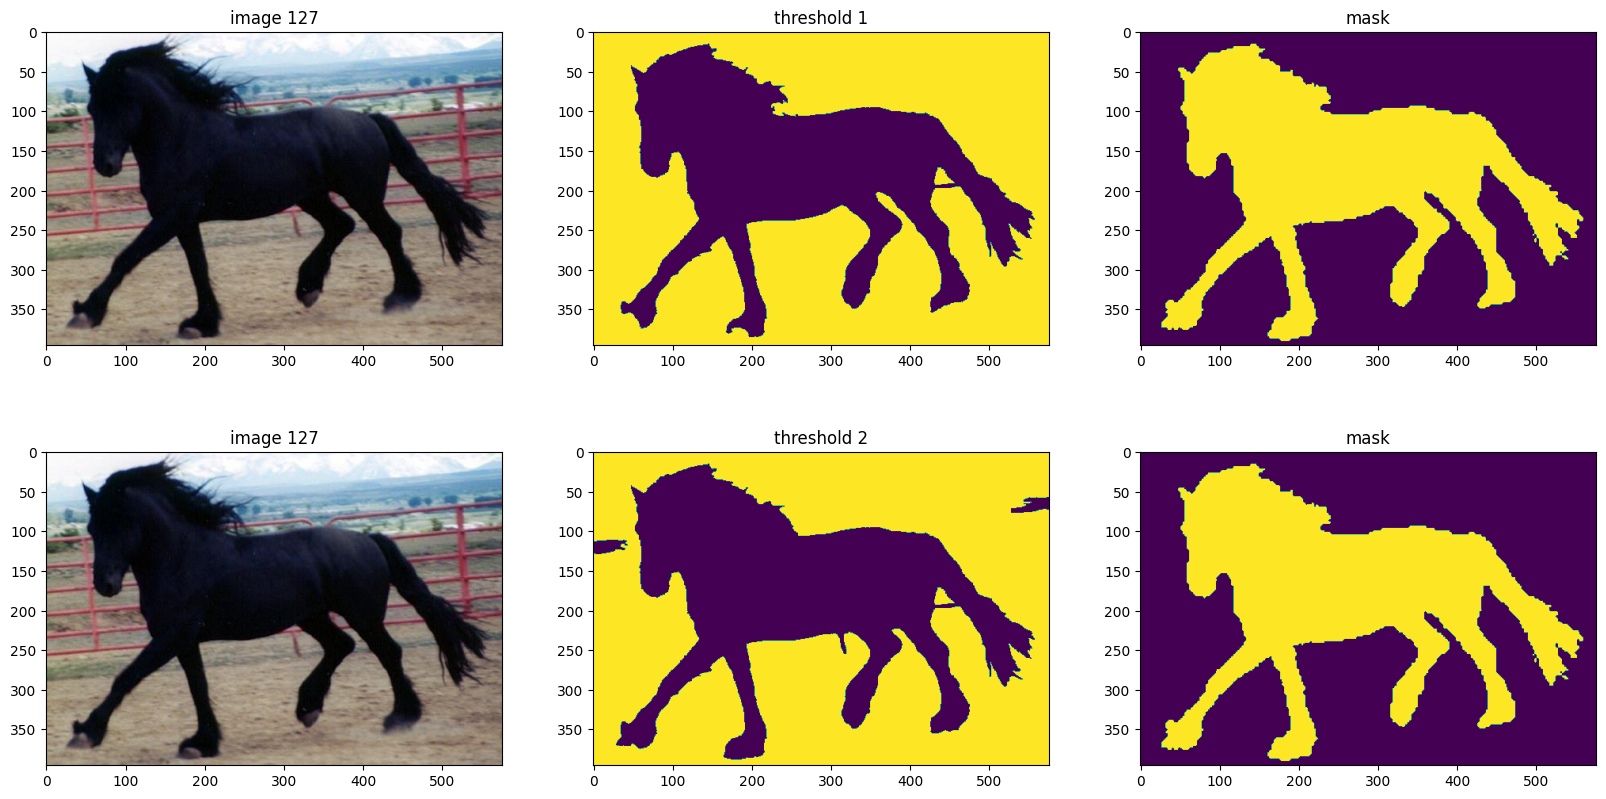

In [35]:
# print the first 3 image on the same line
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.imshow(images[bests_index[0]])
plt.title('image 127')
plt.subplot(1, 3, 2)
plt.imshow(ncut_threshold)
plt.title('threshold 2')
plt.subplot(1, 3, 3)
plt.imshow(imagess[bests_index[0]])
plt.title('mask')
plt.subplot(2, 3, 1)
plt.imshow(images[bests_index[0]])
plt.title('image 127')
plt.subplot(2, 3, 2)
plt.imshow(ncut_threshold2)
plt.title('threshold 1')
plt.subplot(2, 3, 3)
plt.imshow(imagess[bests_index[0]])
plt.title('mask')
plt.show()


In [24]:
best2cut = ncut(images[bests_index[1]])
ncut_threshold = best2cut.copy()
ncut_threshold2 = best2cut.copy()

average = np.average(best2cut)

ncut_threshold[ncut_threshold < average] = 0
ncut_threshold[ncut_threshold >= average] = 1

ncut_threshold2[ncut_threshold2 < average/2] = 0
ncut_threshold2[ncut_threshold2 >= average/2] = 1

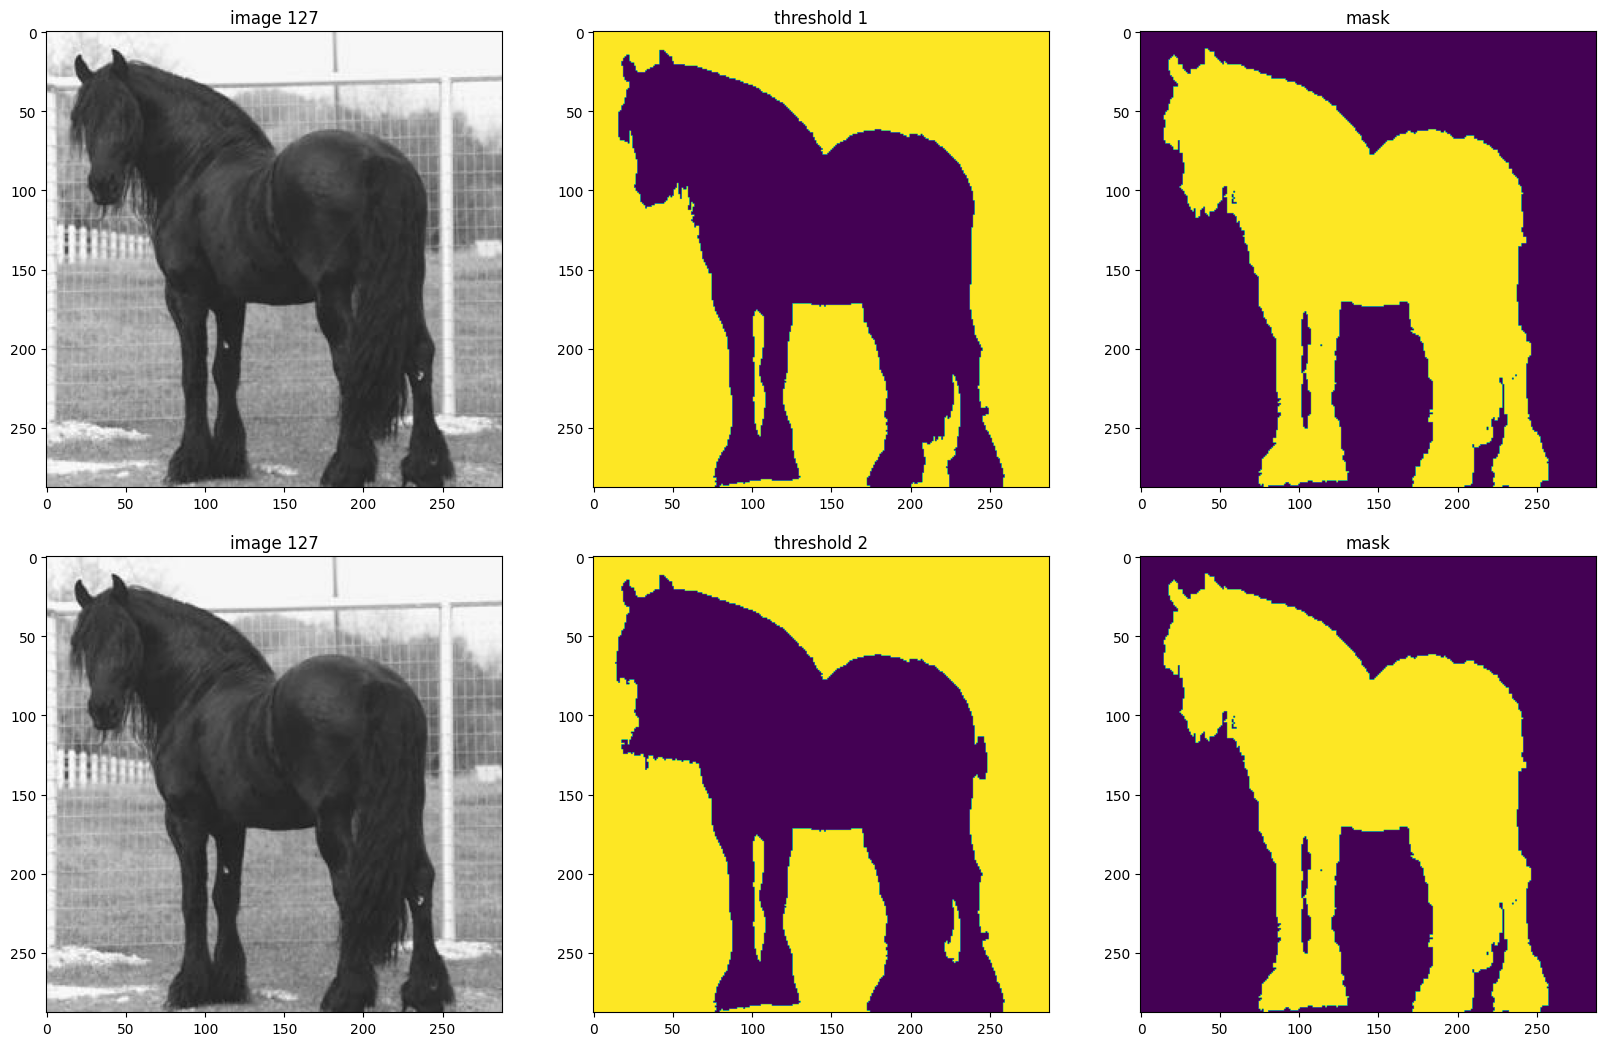

In [25]:
# print the first 3 image on the same line
plt.figure(figsize=(20, 25))
plt.subplot(1, 3, 1)
plt.imshow(images[bests_index[1]])
plt.title('image 127')
plt.subplot(1, 3, 2)
plt.imshow(ncut_threshold)
plt.title('threshold 2')
plt.subplot(1, 3, 3)
plt.imshow(imagess[bests_index[1]])
plt.title('mask')
plt.subplot(2, 3, 1)
plt.imshow(images[bests_index[1]])
plt.title('image 127')
plt.subplot(2, 3, 2)
plt.imshow(ncut_threshold2)
plt.title('threshold 1')
plt.subplot(2, 3, 3)
plt.imshow(imagess[bests_index[1]])
plt.title('mask')
plt.show()


In [26]:
worst = accs2[0]
worst_index = accs.index(worst)

worst2cut = ncut(images[worst_index])
ncut_threshold = worst2cut.copy()
ncut_threshold2 = worst2cut.copy()
ncut_threshold3 = worst2cut.copy()

average = np.average(worst2cut)

ncut_threshold[ncut_threshold < average] = 0
ncut_threshold[ncut_threshold >= average] = 1

ncut_threshold2[ncut_threshold2 < average/2] = 0
ncut_threshold2[ncut_threshold2 >= average/2] = 1

ncut_threshold3[ncut_threshold3 < average/1.83] = 0
ncut_threshold3[ncut_threshold3 >= average/1.83] = 1

# calculating the avg accuracy

In [27]:
average = np.mean(accs2)
average

0.47646853338905604

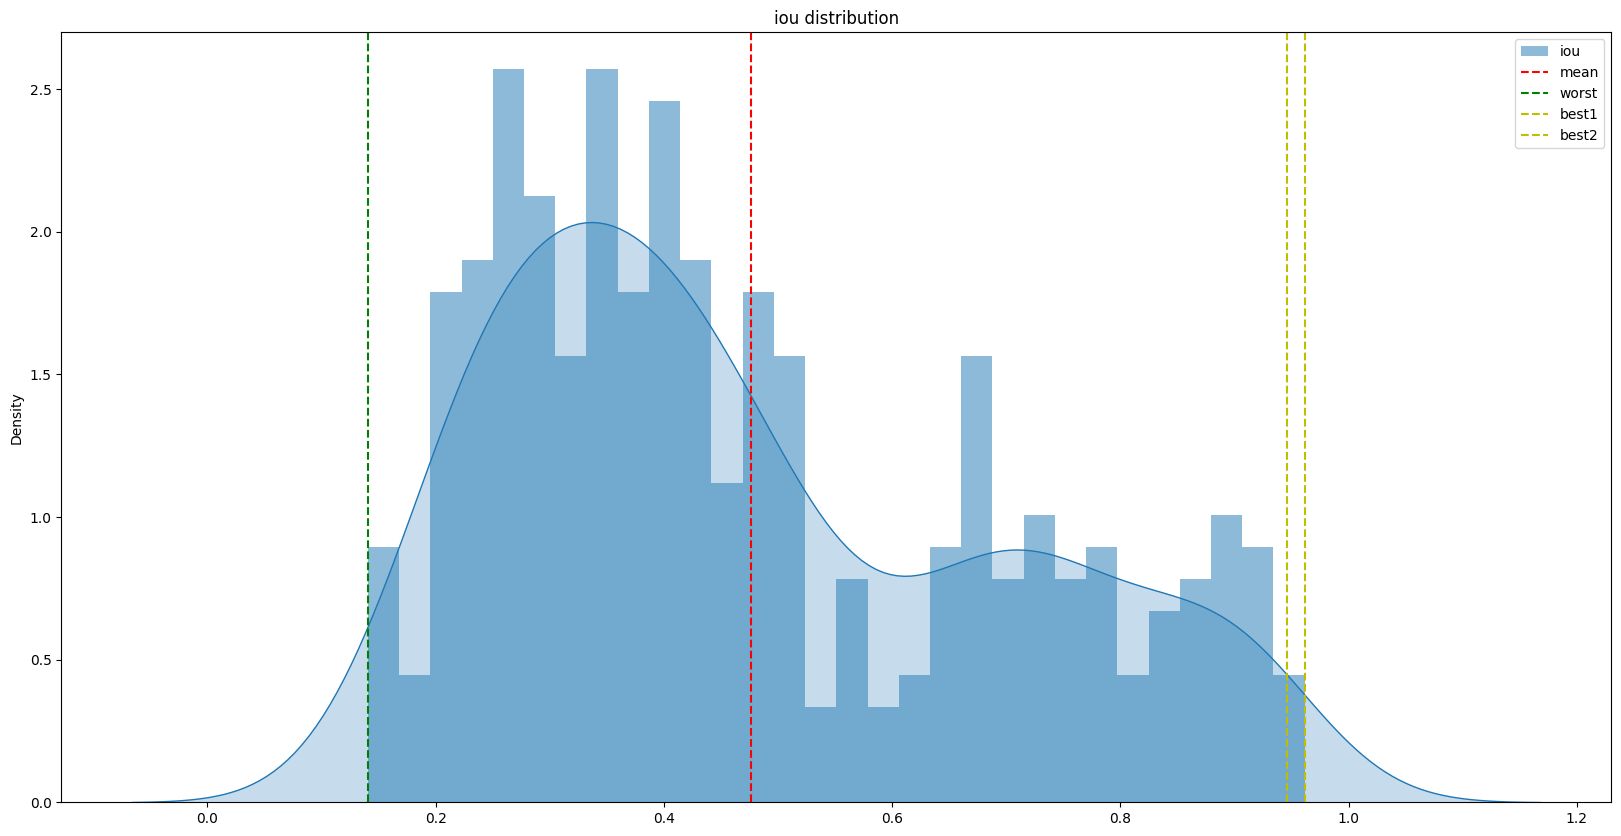

In [28]:
import seaborn as sns
plt.figure(figsize=(20, 10))
plt.hist(accs, bins=30, alpha=0.5, label='iou', density=True)
sns.kdeplot(accs, fill=True)
plt.axvline(x=average, color='r', linestyle='--', label='mean')
plt.axvline(x=worst, color='g', linestyle='--', label='worst')
plt.axvline(x=bests[0], color='y', linestyle='--', label='best1')
plt.axvline(x=bests[1], color='y', linestyle='--', label='best2')
plt.title('iou distribution')
plt.legend()
plt.show()



# analisys

Even tho the best scored results looks very good compared to the ground truth we can see that the average accuracy tends to be not that great. A problem with this approach is that it isn't really generalizable for a wide range of different pictures with different colors, dimensions and luminosity. 

The hyperparameters to choose are many (number of superpixels, compactess, threshold and sigma for the ncut, number of iterations etc.) and each image favors a specific combination, there is note a global better one that works well with each image. 

Furthermore the ncut algorithm will return a segmentated image that will consists of many labels, not a binary mask like the ground truth.

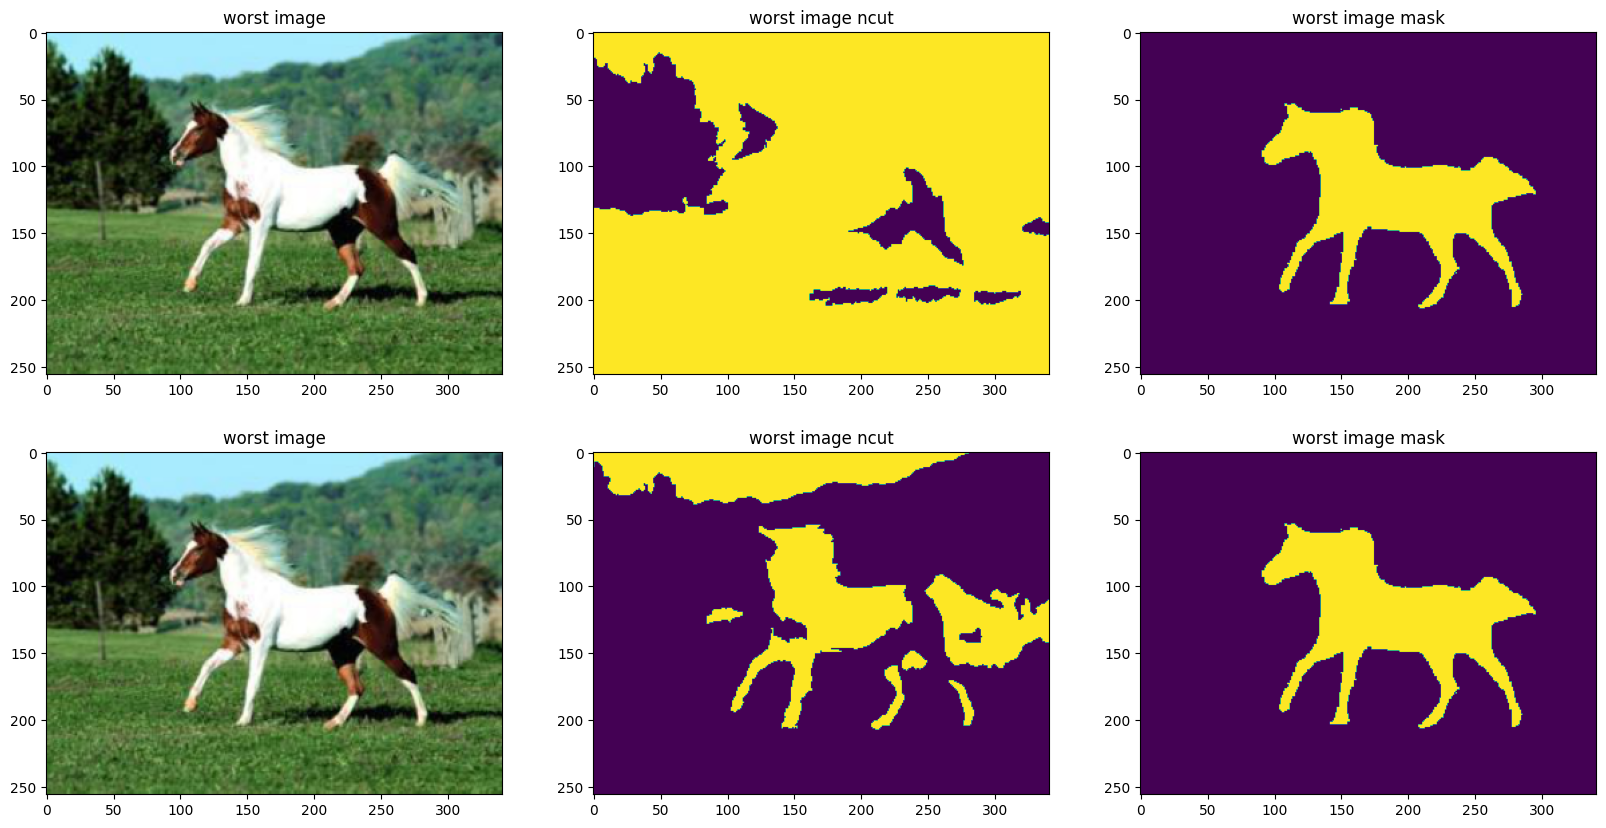

In [29]:
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.imshow(images[worst_index])
plt.title('worst image')
plt.subplot(1, 3, 2)
plt.imshow(ncut_threshold)
plt.title('worst image ncut')
plt.subplot(1, 3, 3)
plt.imshow(imagess[worst_index])
plt.title('worst image mask')
plt.subplot(2, 3, 1)
plt.imshow(images[worst_index])
plt.title('worst image')
plt.subplot(2, 3, 2)
plt.imshow(ncut_threshold2)
plt.title('worst image ncut')
plt.subplot(2, 3, 3)
plt.imshow(imagess[worst_index])
plt.title('worst image mask')
plt.show()

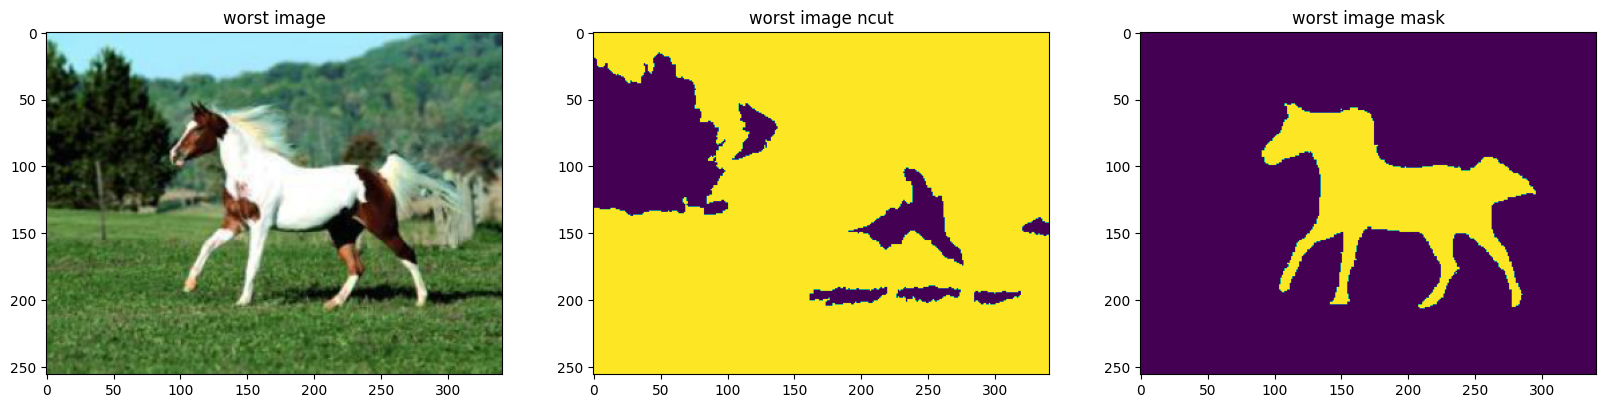

In [30]:
plt.figure(figsize=(20, 20))
plt.subplot(3, 3, 1)
plt.imshow(images[worst_index])
plt.title('worst image')
plt.subplot(3, 3, 2)
plt.imshow(ncut_threshold3)
plt.title('worst image ncut')
plt.subplot(3, 3, 3)
plt.imshow(imagess[worst_index])
plt.title('worst image mask')
plt.show()

In [31]:
img_pred = np.array(ncut_threshold3).ravel()
img_true = np.array(imagess[worst_index]).ravel()
iou = max(jaccard_score(img_true, img_pred), jaccard_score(img_true, (1-img_pred)))
iou

0.12506182802697002